# WQD7005 Data Mining

# Milestone 4

In [36]:
#importing libraries
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

import pyodbc

# 1.Access data from Hive database

In [10]:
conn = pyodbc.connect(DSN = "hive_connection", autocommit = True, ansi = True)

print(conn)

In [11]:
df = pd.read_sql("SELECT * FROM bitcoin", conn, parse_dates=['date'])
df.head()

,bitcoin.marketdate,bitcoin.open,bitcoin.high,bitcoin.low,bitcoin.close,bitcoin.volume,bitcoin.marketcapacity
0,2020-05-25,8786.11,8951.01,8719.67,8906.93,3.128816e+10,1.637605e+11
1,2020-05-24,9212.28,9288.40,8787.25,8790.37,3.251880e+10,1.616104e+11
2,2020-05-23,9185.06,9302.50,9118.11,9209.29,2.772787e+10,1.693055e+11
3,2020-05-22,9080.33,9232.94,9008.64,9182.58,2.981077e+10,1.688076e+11
4,2020-05-21,9522.74,9555.24,8869.93,9081.76,3.932616e+10,1.669480e+11


In [12]:
df = df[::-1].reset_index(drop=True) # sort date and reindex
btc = df.set_index('bitcoin.marketdate')
btc.index = pd.to_datetime(btc.index)
target_col = 'close'
btc.head(5)

,bitcoin.open,bitcoin.high,bitcoin.low,bitcoin.close,bitcoin.volume,bitcoin.marketcapacity
bitcoin.marketdate,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,0.0,1.488567e+09
2013-04-29,134.44,147.49,134.00,144.54,0.0,1.603769e+09
2013-04-30,144.00,146.93,134.05,139.00,0.0,1.542813e+09
2013-05-01,139.00,139.89,107.72,116.99,0.0,1.298955e+09
2013-05-02,116.38,125.60,92.28,105.21,0.0,1.168517e+09


# 2.Prepare data for training and testing.

In [13]:
def train_test_split(btc, test_size=0.2):
    split_row = len(btc) - int(test_size * len(btc))
    train_data = btc.iloc[:split_row]
    test_data = btc.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(btc, test_size=0.2)

split the data into two sets — training set and test set with 80% and 20% data respectively.

In [14]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Closing price ', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)  

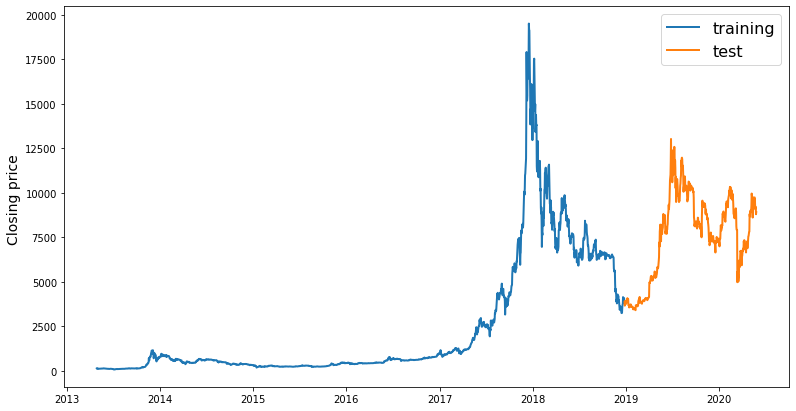

In [16]:
line_plot(train['bitcoin.close'], test['bitcoin.close'], 'training', 'test', title='')

# 3.Predict the price of crptocurrency using LSTM neural network.

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [17]:
data = btc.iloc[:, 0]
history = []
target = []
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    history.append(x)
    target.append(y)

In [18]:
history = np.array(history)  # convert data to numpy array and reshape the target

target = np.array(target)
target = target.reshape(-1,1)

print(history.shape, target.shape)

(2495, 90) (2495, 1)


In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
history_scaled = scaler.fit_transform(history)
target_scaled = scaler.fit_transform(target)

In [22]:

history_scaled = history_scaled.reshape((len(history_scaled), length, 1))

print(history_scaled.shape) # reshape the input array to be compatible with LSTM model

(2495, 90, 1)


In [23]:
X_train = history_scaled[:2400,:,:] # 2400 days used for training whereas 95 days used for testing
X_test = history_scaled[2400:,:,:]

y_train = target_scaled[:2400,:]
y_test = target_scaled[2400:,:]

# Build a LSTM Model

In [24]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss=loss, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

Sequential model is used for stacking all the layers (input, hidden and output). The neural network comprises of a LSTM layer followed by 20% Dropout layer and a Dense layer with linear activation function. I complied the model using Adam as the optimizer and Mean Squared Error as the loss function.

In [4]:
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 30
batch_size = 32
loss = 'mean_squared_error'
dropout = 0.2
optimizer = 'adam'
target_col = ['bitcoin.close']

set up some of the parameters to be used later. These parameters are —  length of the window, test set size in LSTM layer, epochs, batch size, loss, dropouts and optimizer.

In [29]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Training the model

train the model using inputs x_train and labels y_train.

In [30]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
2400/2400 [==============================] - 63s 26ms/step - loss: 0.0186
Epoch 2/30
2400/2400 [==============================] - 30s 13ms/step - loss: 0.0118
Epoch 3/30
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0129
Epoch 4/30
2400/2400 [==============================] - 35s 15ms/step - loss: 0.0139
Epoch 5/30
2400/2400 [==============================] - 45s 19ms/step - loss: 0.0094
Epoch 6/30
2400/2400 [==============================] - 47s 20ms/step - loss: 0.0071
Epoch 7/30
2400/2400 [==============================] - 53s 22ms/step - loss: 0.0033
Epoch 8/30
2400/2400 [==============================] - 27s 11ms/step - loss: 0.0030
Epoch 9/30
2400/2400 [==============================] - 17s 7ms/step - loss: 0.0023
Epoch 10/30
2400/2400 [==============================] - 45s 19ms/step - loss: 0.0021
Epoch 11/30
2400/2400 [==============================] -

In [35]:
targets = y_test
#targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, targets)

0.08529373080285942

# 4.Visualize the prediction results

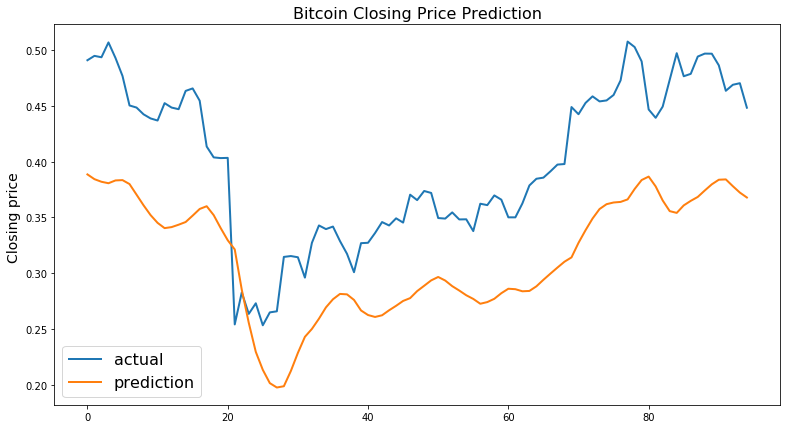

In [33]:
line_plot(targets, preds, 'actual', 'prediction', title='Bitcoin Closing Price Prediction')

# Conclusion

After 4 step processing of getting close price prediction of Cryptocurrecy data, the result shown bad prediction because the prediction receive the overfitting based on above graph show.
Feel free to play with the hyper-parameters or try out different neural network architectures for better results.